In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys

In [3]:
os.chdir('/content/drive/MyDrive/Test_case/Figures_detection/detecror_training_2/')
sys.path.append('/content/drive/MyDrive/Test_case/Figures_detection')
sys.path.append('/content/drive/MyDrive/Test_case')

# Imports setup

In [4]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as F
from tqdm import tqdm
from utils.loss import lossYolov1
from yolov_1_model import YOLO_model
from detecror_training_2.utils.metrics import *
from detecror_training_2.utils.utils import save_checkpoint, load_checkpoint, update_dataset_info
from detecror_training_2.utils.dataloaders import get_loaders, ShapeDatasetFromGenerator
import pandas as pd
import pickle
from torch.utils.data import DataLoader




In [5]:

EPOCHS = 5 # 16
TEST_SIZE_DATA = 24
TRAIN_SIZE_DATA = 64
BATCH_SIZE = 4
LEARN_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHT_DECAY = 0
CHECK_PATH = './checkpoints'
RESIZE_SHAPE = 256
MODEL_VERSION = "v1" + ".pth.tar"
TEST_RUNS_RES = './runs/test'
TRAIN_RUNS_RES = './runs/train'
LABEL_DIR = './dataset_batches_generated'
TEST_SIZE_DATA = 24
TRAIN_SIZE_DATA = 64



# Base classes and functions

In [6]:

class Compose(object):
    def __init__(self, tfs):
        self.tfs = tfs

    def __call__(self, img, bboxes):
        for t in self.tfs:
            img, bbox = t(img), bboxes
        return img, bbox



def get_iou(true_boxes, pred_boxes, n_classes = 4):
    iou_list = []
    for c in range(n_classes):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x: x[2], reverse=True)
        total_true_bboxes = len(ground_truths)

        # print("total_true_bboxes = ", total_true_bboxes)
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format="midpoint",
                )
                iou_list.append(iou.item())

    return iou_list

def inference(model, loader, epoch, save_image_detected_res = None, save_dataframe_path = None,  img_label = ''):
    iou_per_batch = []

    # iterate through __len__ annotations in DataLoadeers
    # in order to get 1000 images for inference testing we should run get_bboxes() n times
    # n = 1000 // TEST_SIZE_DATA = 1000 / 24 = 42 times
    # ### FOR TEST INFERENCE
    mean_iou, max_iou, min_iou, recall, precision, maP = 0, 0, 0, 0, 0, 0

    if save_dataframe_path is not None:
        test_inference_times = 4 #42
    else:
        test_inference_times = 1

    for i in range(test_inference_times):
        all_pred_boxes, all_true_boxes = get_bboxes( loader = loader, model = model,iou_threshold = 0.5,\
                                                    threshold = 0.5, save_image_detected_res=save_image_detected_res, epoch =  epoch , inference_time = i)

        true_boxes = torch.Tensor(all_true_boxes)
        pred_boxes =  torch.Tensor(all_pred_boxes)
        iou_list = get_iou(all_true_boxes, all_pred_boxes)

        # GET BASE METRICS
        mean_iou += np.mean(iou_list) / test_inference_times
        max_iou += max(iou_list) / test_inference_times
        min_iou += min(iou_list) / test_inference_times

        mAPrecision, precisions_list, recall_list = mean_average_precision(all_pred_boxes, all_true_boxes, iou_threshold=0.5, get_prec_rec = True)
        mAPrecision += mAPrecision.item() / test_inference_times
        recall += np.mean(recall_list) / test_inference_times
        precision += np.mean(precisions_list) / test_inference_times


    df = pd.DataFrame(data={
        "MODEL_VERSION" : MODEL_VERSION,
        "epoch": epoch,
        "mean_iou" : mean_iou ,
        "max_iou": max_iou,
        "min_iou": min_iou,
        "precision": precision ,
        "recall": recall,
        "mAP.0.5" : mAPrecision
    },  index=[0])

    with pd.option_context('display.max_rows', 100,
                           'display.max_columns', 20,
                           'display.precision', 5
                           ):
        print(df)
    if save_dataframe_path is not None:
        df.to_csv(save_dataframe_path + f'/metrics_{MODEL_VERSION}__{epoch}.csv')



In [7]:

def train_function(yolo_model, train_loader, optimizer, loss_fn , model_version, load_check):
    loss_per_train = []

    yolo_model = yolo_model.to(DEVICE)
    n_images = 0
    n_img_per_class_epoch = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,

    }

    for i, (x, y) in enumerate(train_loader):
        n_images += (len(x))
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = yolo_model(x)
        loss = loss_fn(preds, y)
        print("\n## TRAIN LOSS ## = ", loss.item())
        optimizer.zero_grad()
        loss_per_train.append(loss.item())
        loss.backward()
        optimizer.step()
        n_img_per_class_epoch = update_dataset_info(path_annotations = LABEL_DIR + '/annotations_txt', dict_to_update=n_img_per_class_epoch)


    return sum(loss_per_train) / len(loss_per_train), n_img_per_class_epoch , n_images

def save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION):
    info = {
        "n_images" : n_images,
        "n_img_per_class_epoch" : n_img_per_class_epoch
    }
    with open(TRAIN_RUNS_RES + f'/train_meta_{epoch}_{MODEL_VERSION}.pickle', 'wb') as handle:
        pickle.dump(info, handle)


In [8]:

def run(save_dataframe_path=TEST_RUNS_RES, load_check = ''):
    tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])

    model = YOLO_model(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)
    train_loader, test_loader = get_loaders(tfs, BATCH_SIZE,  TRAIN_SIZE_DATA, TEST_SIZE_DATA)
    loss_fn = lossYolov1()
    opt = optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    loss_per_epoch = []
    model = model.to(DEVICE)
    try:
        model, opt = load_checkpoint(checkpoint_path= load_check, model=model, optimizer=opt)
        print("LOADED WEIGHTS")
    except:
        print("\n====================\n  looks like we gonna train from scratch  \n======================")


    for epoch in range(EPOCHS):
        # #################
        # CALCULATE METRICS
        # #################
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"## EPOCH = {epoch} ##  mean_avg_prec =  {mean_avg_prec}")


        avg_train_loss , n_img_per_class_epoch , n_images = train_function(yolo_model=model, train_loader = train_loader, \
                           optimizer = opt, loss_fn = loss_fn, model_version = MODEL_VERSION, load_check=load_check)

        loss_per_epoch.append(avg_train_loss)

        save_checkpoint(epoch = epoch, model = model, optimizer = opt, LOSS = avg_train_loss,\
                        path = CHECK_PATH, filename=f"/yolo_{epoch}_" + MODEL_VERSION )

        save_losses(loss_per_epoch, MODEL_VERSION)

        save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION)
        # if ( epoch % 7 == 0 ) or ( epoch == EPOCHS-1 ):
        if ( epoch % 2 == 0 ) or ( epoch == EPOCHS-1 ):
            print("#  INFERENCE TRAIN STARTS HERE...   #   ")
            inference(model, train_loader, epoch, save_dataframe_path=None, img_label = f"train_epoch_{epoch}")
            print("#  INFERENCE TEST STARTS HERE...   #   ")
            inference(model, test_loader, epoch, save_dataframe_path=save_dataframe_path, save_image_detected_res=save_dataframe_path, img_label = f"test_epoch_{epoch}")
            # for x, y in train_loader:  # see results during training
            #     x = x.to(DEVICE)
            #     for idx in range(1):
            #         bboxes = cellboxes_to_boxes(model(x))
            #         bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.5, box_format="midpoint")
            #         plot_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes, idx=idx)



# Run train

### Run

In [9]:
import warnings
warnings.filterwarnings('ignore')


  looks like we gonna train from scratch  
## EPOCH = 0 ##  mean_avg_prec =  0.0

## TRAIN LOSS ## =  119.91423034667969

## TRAIN LOSS ## =  135.76535034179688

## TRAIN LOSS ## =  35.437435150146484

## TRAIN LOSS ## =  84.60913848876953

## TRAIN LOSS ## =  42.17015838623047

## TRAIN LOSS ## =  59.5177001953125

## TRAIN LOSS ## =  62.912010192871094

## TRAIN LOSS ## =  59.5191650390625

## TRAIN LOSS ## =  103.9521713256836

## TRAIN LOSS ## =  83.71063995361328

## TRAIN LOSS ## =  43.21748352050781

## TRAIN LOSS ## =  77.66915130615234

## TRAIN LOSS ## =  46.78105163574219

## TRAIN LOSS ## =  40.733055114746094

## TRAIN LOSS ## =  63.82488250732422

## TRAIN LOSS ## =  63.281654357910156
=> Saving checkpoint. LOSS =  70.1884548664093
#  INFERENCE TRAIN STARTS HERE...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v1.pth.tar      0   0.00359  0.53889      0.0    0.00293  0.00499   

          mAP.0.5  
0  tensor(0.0006)  
#  INFERENCE 

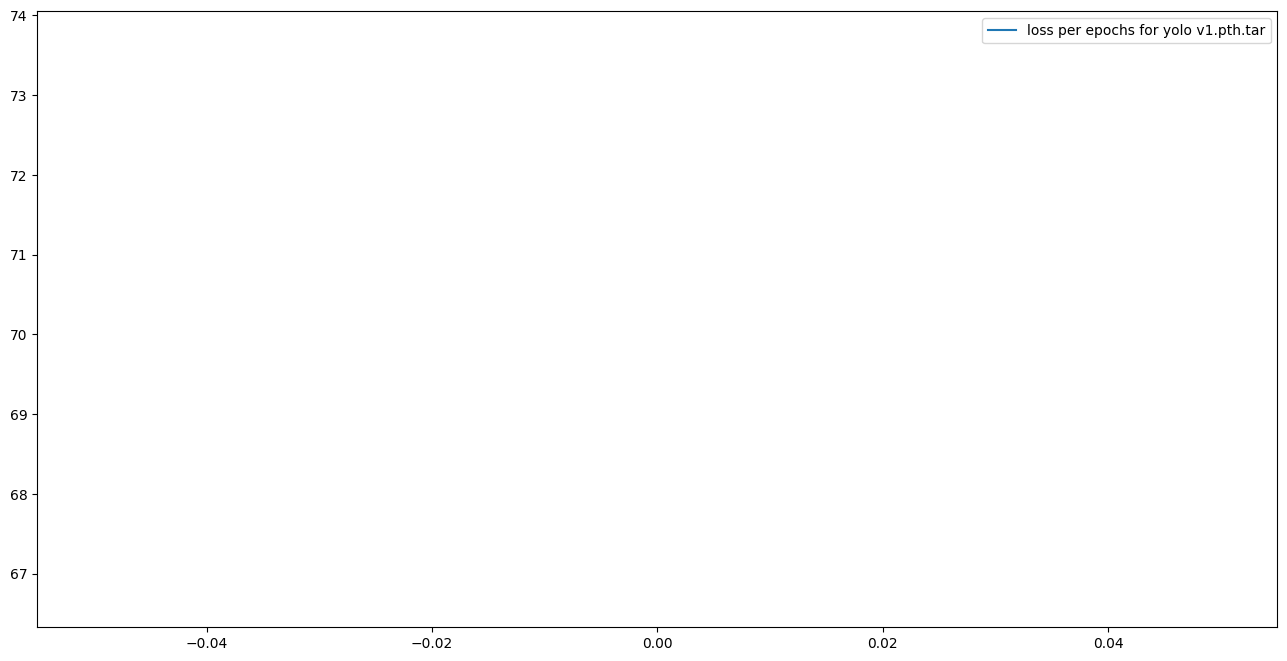

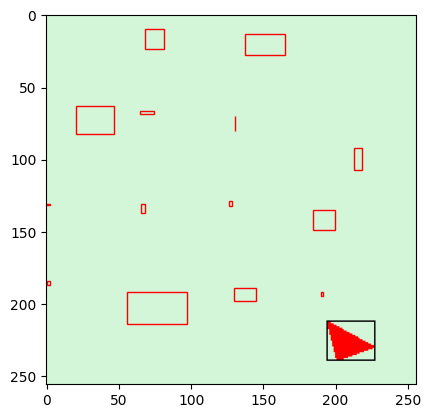

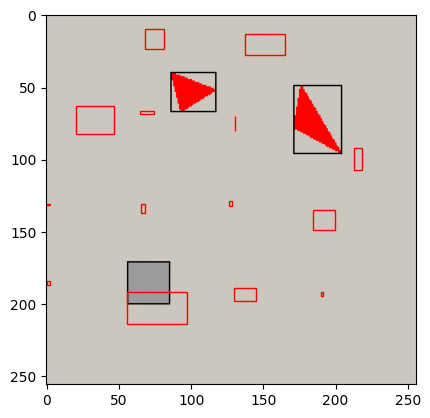

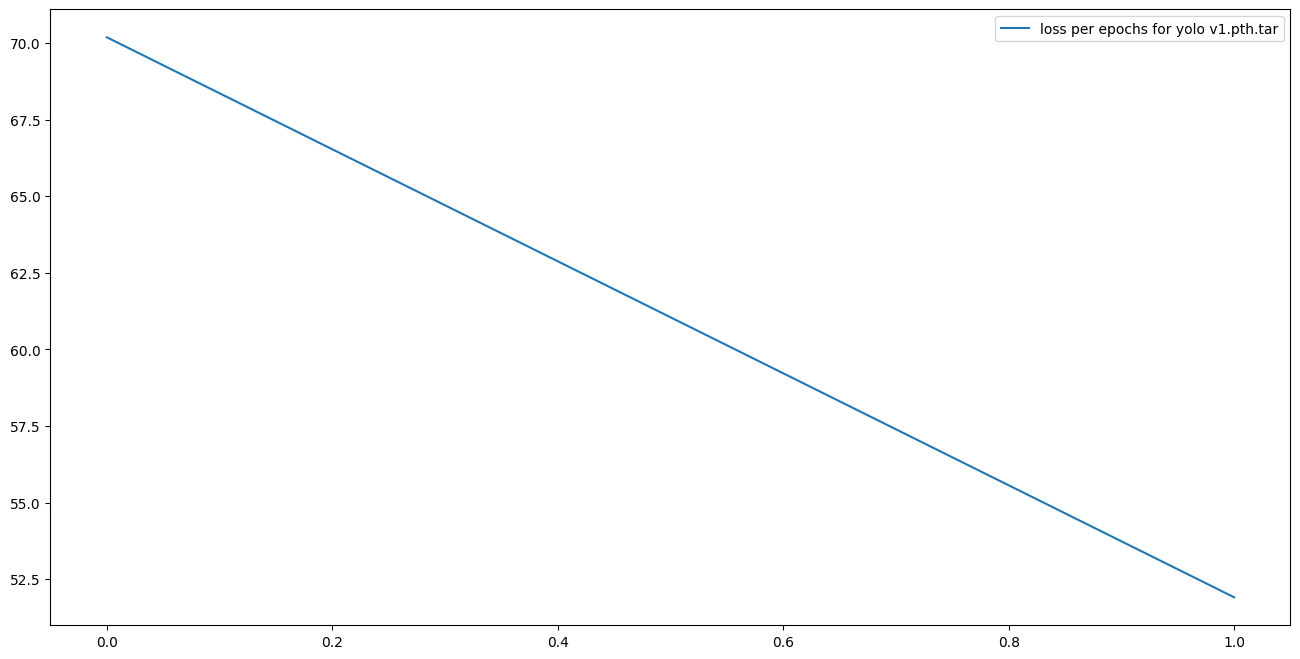

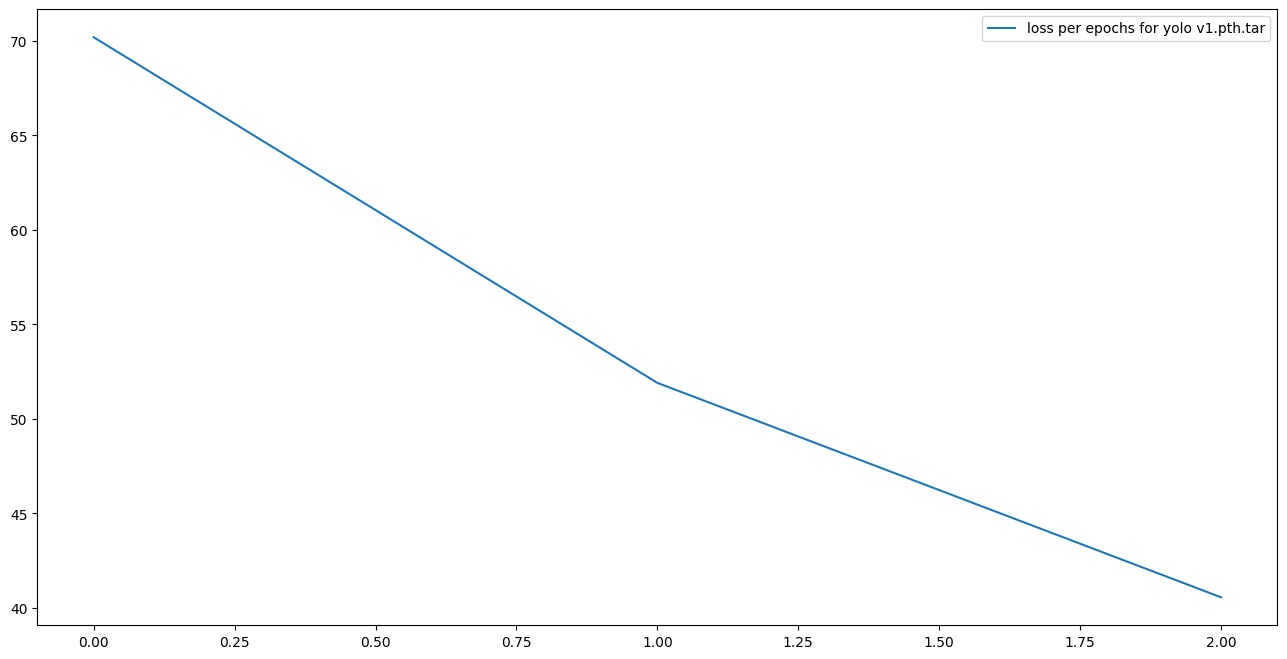

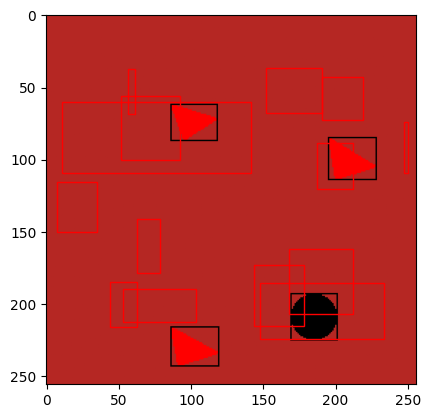

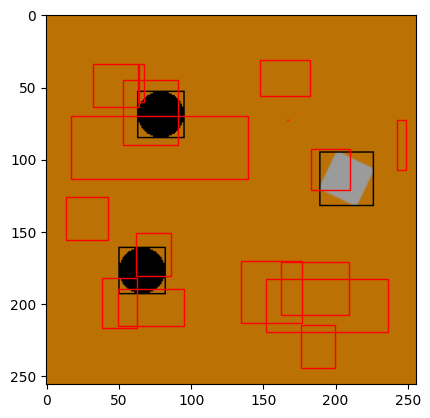

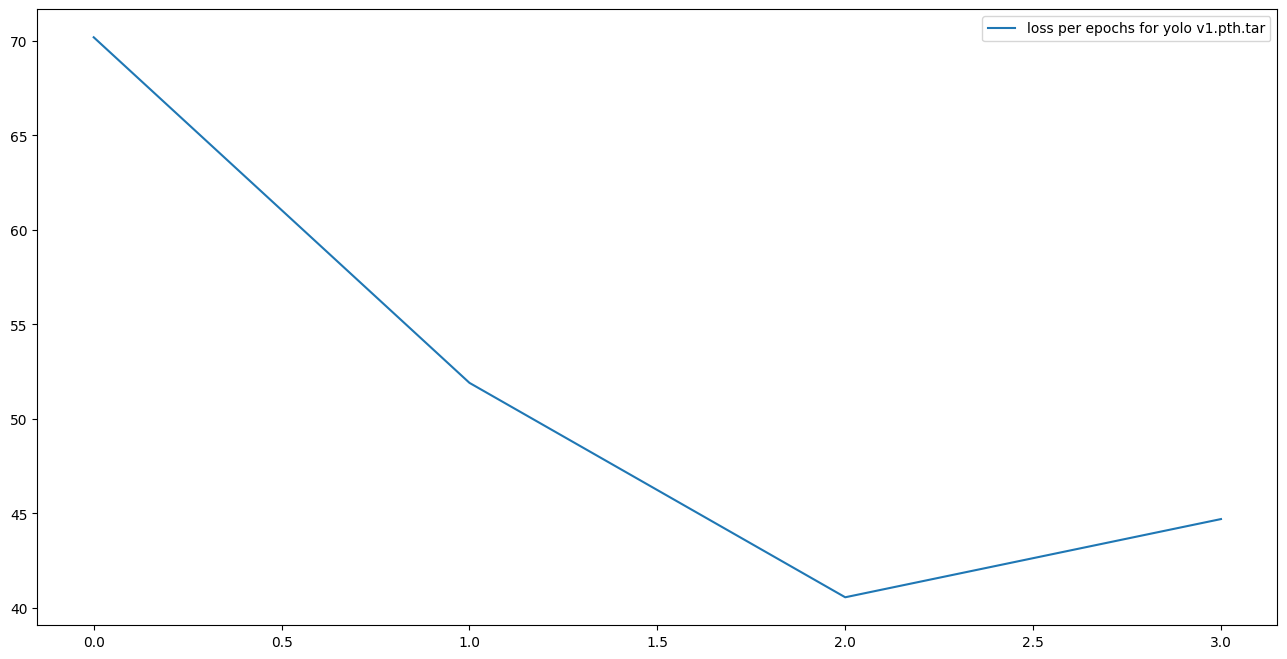

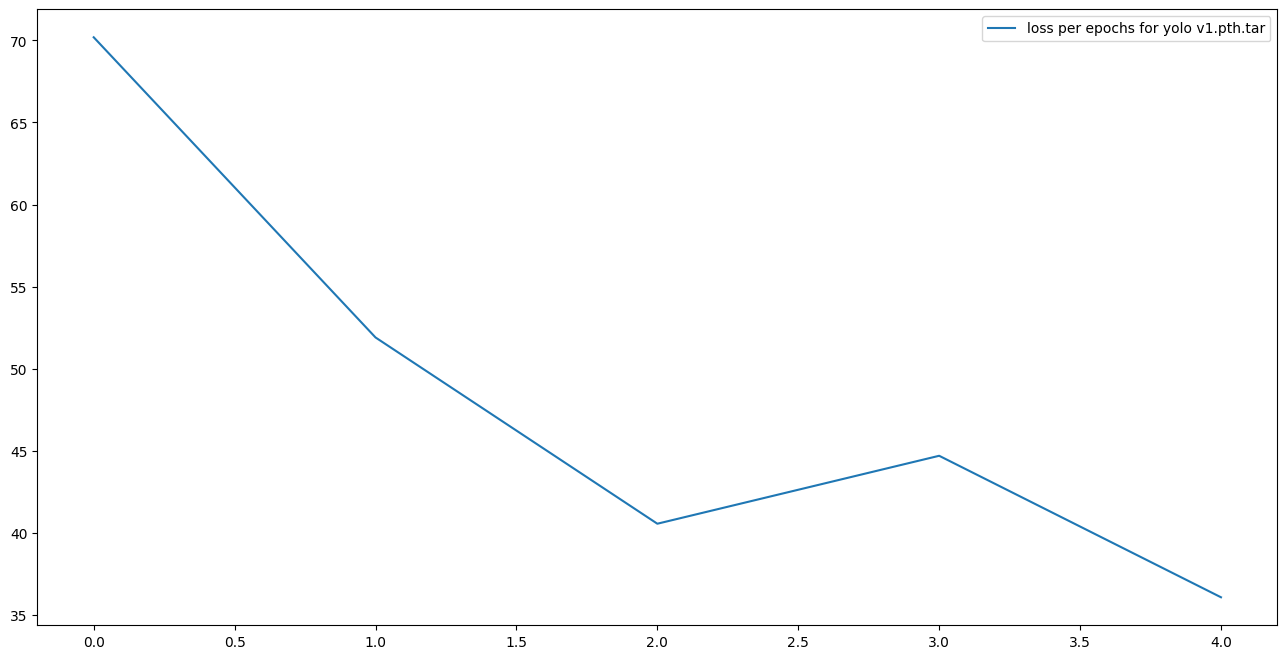

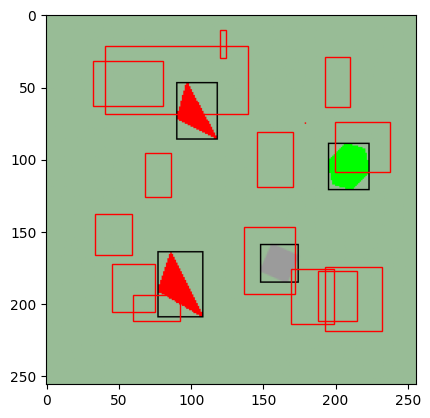

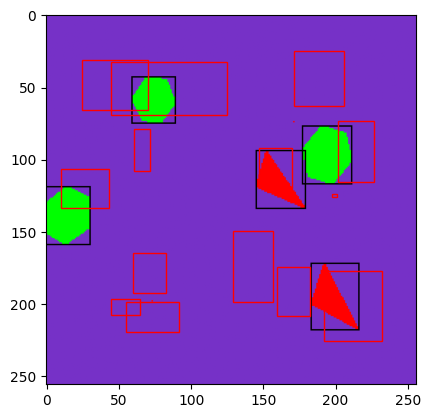

In [10]:
run()

=> Loaded checkpoint
LOADED WEIGHTS
## EPOCH = 0 ##  mean_avg_prec =  0.0005524227162823081

## TRAIN LOSS ## =  41.20111846923828

## TRAIN LOSS ## =  35.255645751953125

## TRAIN LOSS ## =  38.3248176574707

## TRAIN LOSS ## =  28.393640518188477

## TRAIN LOSS ## =  31.364578247070312

## TRAIN LOSS ## =  26.3830623626709

## TRAIN LOSS ## =  33.10950469970703

## TRAIN LOSS ## =  45.10215759277344

## TRAIN LOSS ## =  32.3037223815918

## TRAIN LOSS ## =  38.62340545654297

## TRAIN LOSS ## =  31.19448471069336

## TRAIN LOSS ## =  35.81092071533203

## TRAIN LOSS ## =  35.83815002441406

## TRAIN LOSS ## =  39.48564910888672

## TRAIN LOSS ## =  56.724281311035156

## TRAIN LOSS ## =  48.15159225463867
=> Saving checkpoint. LOSS =  37.32917070388794
#  INFERENCE TRAIN STARTS HERE...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v2.pth.tar      0   0.02919  0.73297      0.0     0.0086  0.00898   

          mAP.0.5  
0  tensor(0.0007)  
#  IN

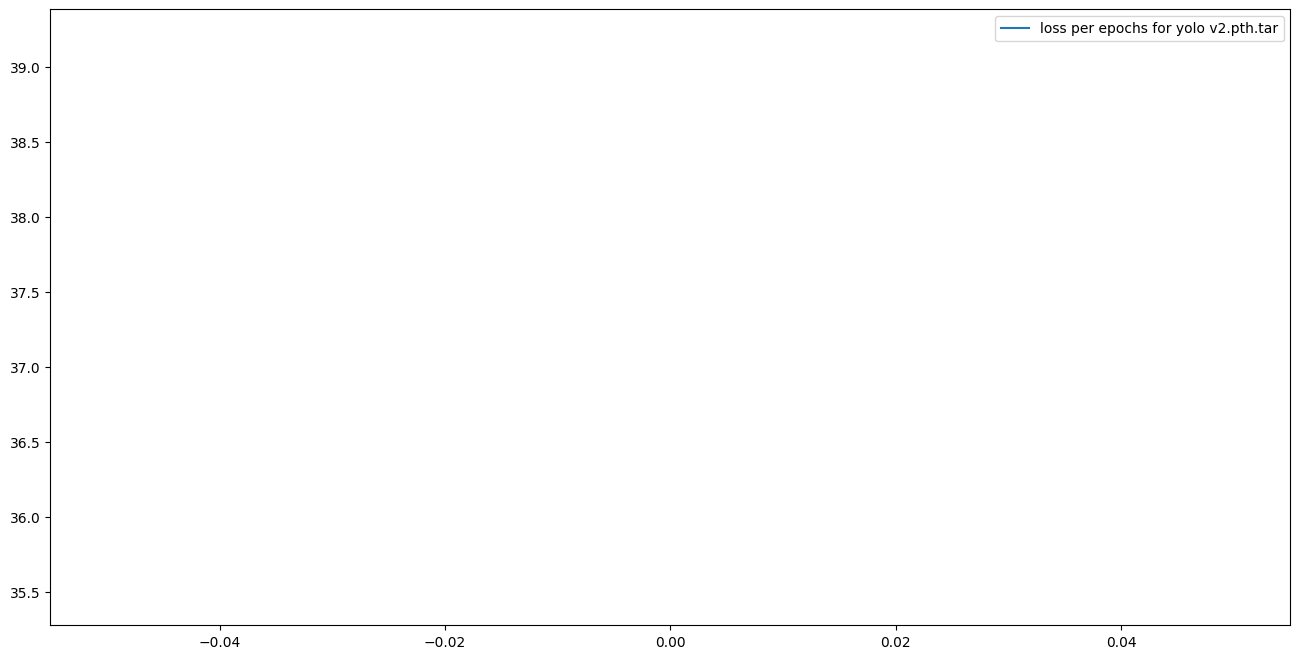

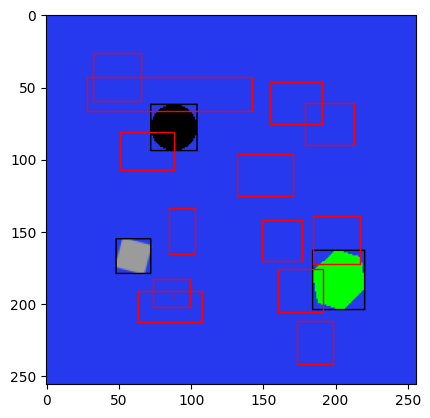

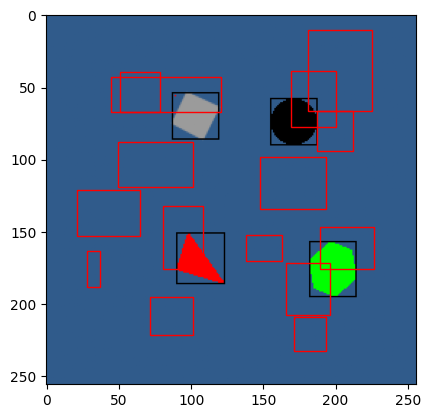

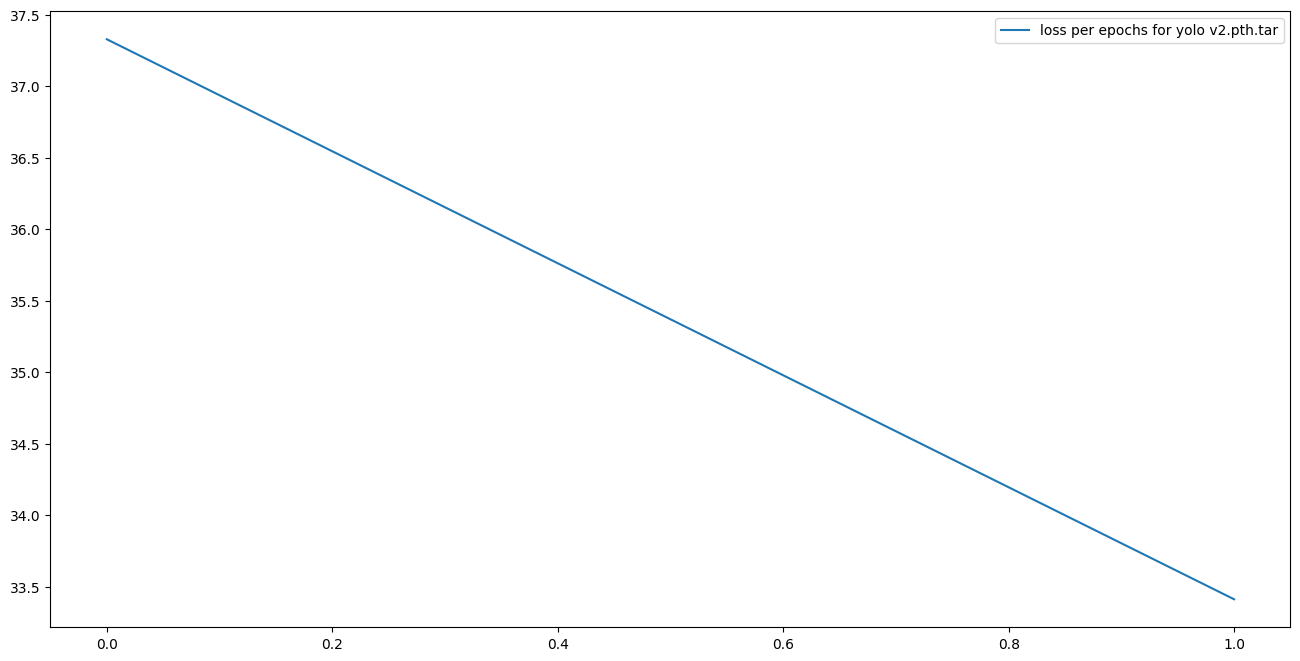

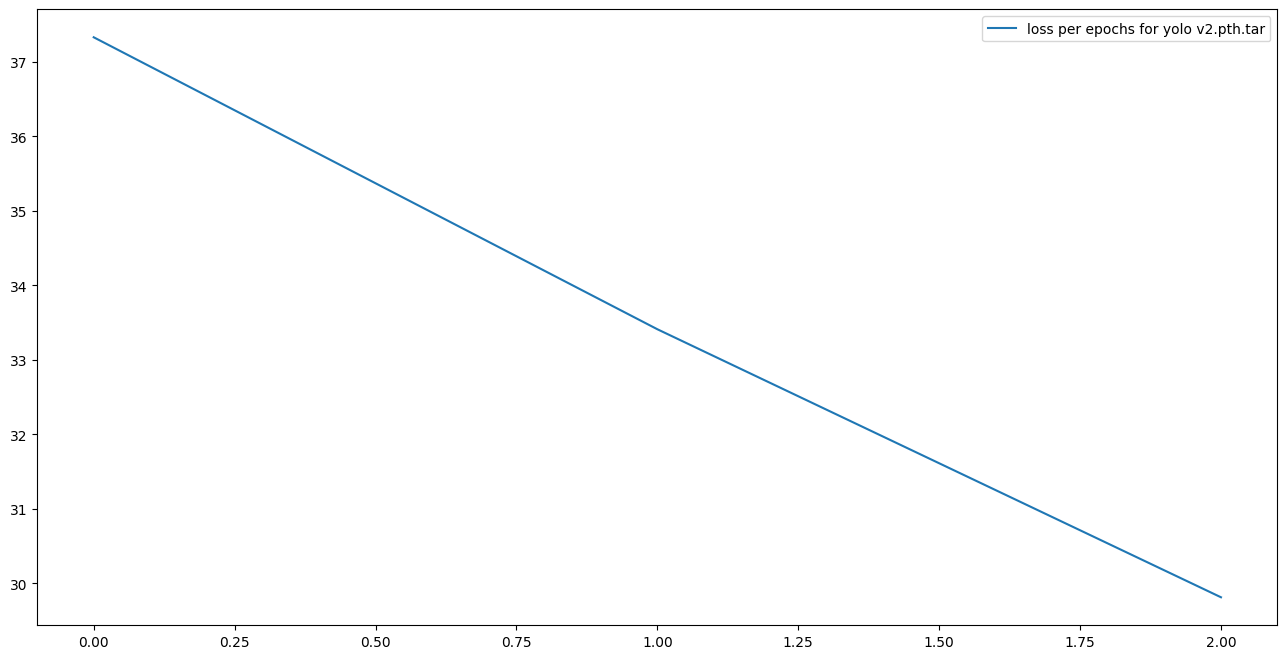

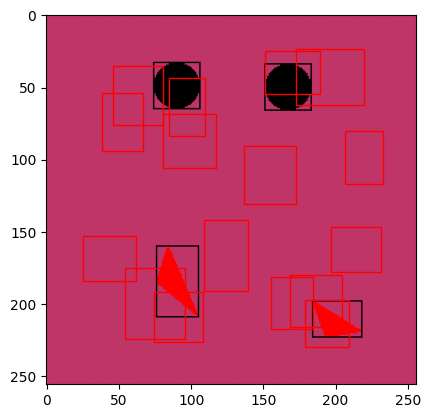

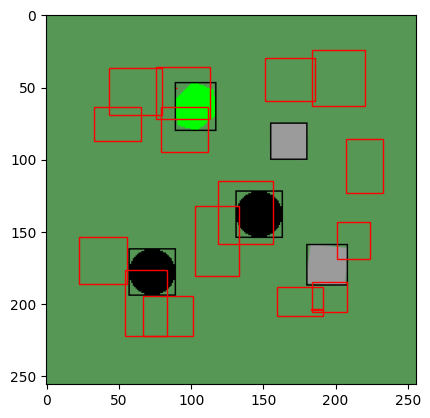

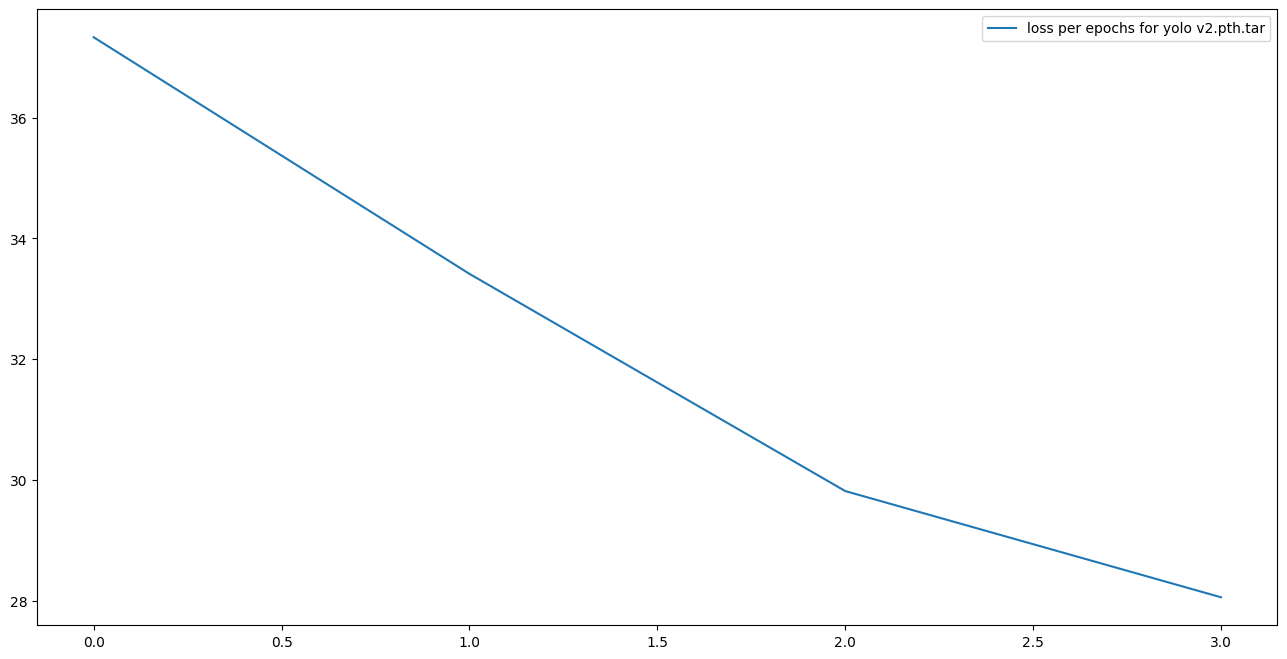

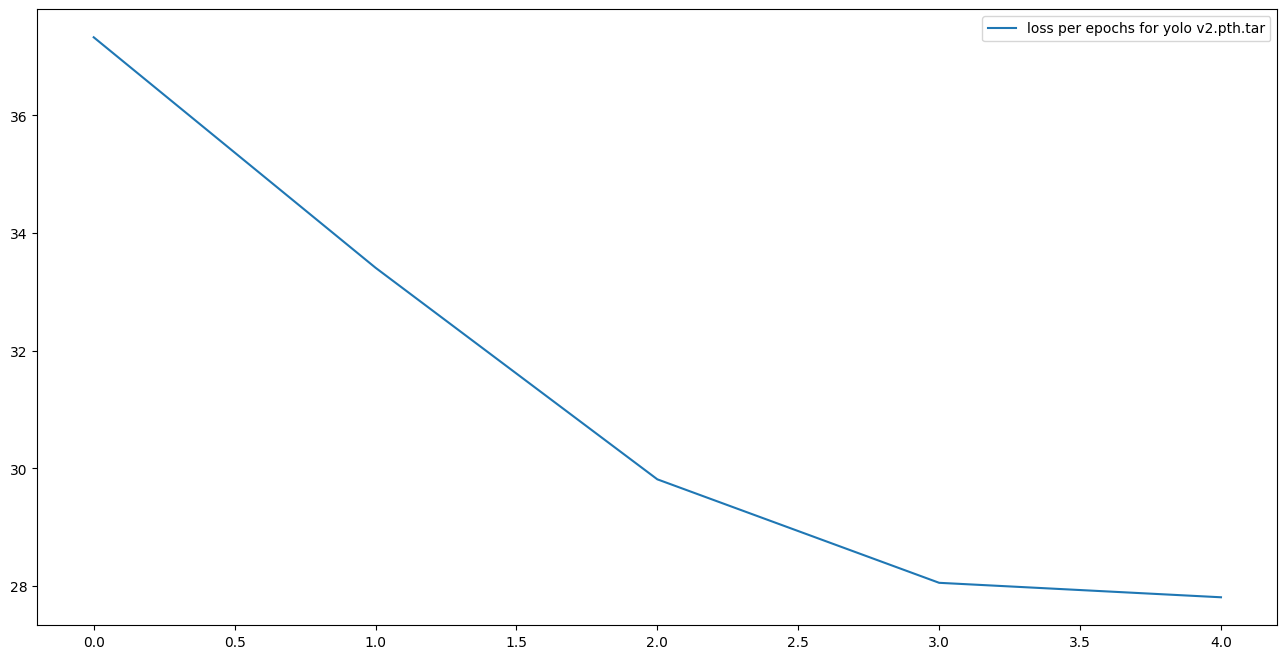

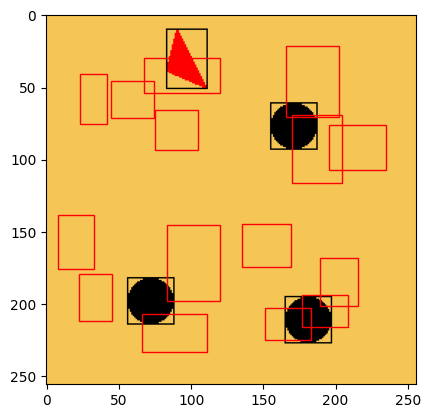

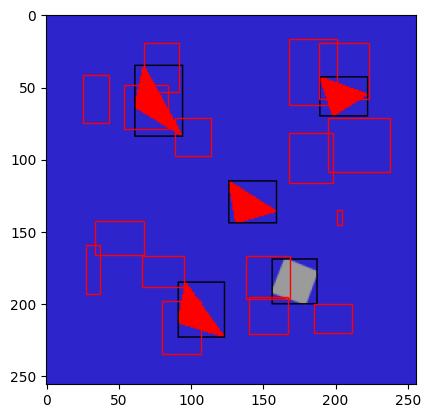

In [8]:
MODEL_VERSION = "v2" + ".pth.tar"
run(load_check = './checkpoints/yolo_4_v1.pth.tar')

=> Loaded checkpoint
LOADED WEIGHTS
## EPOCH = 0 ##  mean_avg_prec =  0.0018985120113939047

## TRAIN LOSS ## =  20.256650924682617

## TRAIN LOSS ## =  29.07928466796875

## TRAIN LOSS ## =  19.223648071289062

## TRAIN LOSS ## =  34.134910583496094

## TRAIN LOSS ## =  34.348182678222656

## TRAIN LOSS ## =  21.076580047607422

## TRAIN LOSS ## =  20.9254150390625

## TRAIN LOSS ## =  27.106945037841797

## TRAIN LOSS ## =  22.53232192993164

## TRAIN LOSS ## =  34.735694885253906

## TRAIN LOSS ## =  26.82731819152832

## TRAIN LOSS ## =  20.772552490234375

## TRAIN LOSS ## =  26.655925750732422

## TRAIN LOSS ## =  33.70589828491211

## TRAIN LOSS ## =  20.878047943115234

## TRAIN LOSS ## =  21.407875061035156
=> Saving checkpoint. LOSS =  25.85420322418213
#  INFERENCE TRAIN STARTS HERE...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v3.pth.tar      0   0.04814  0.63521      0.0    0.02299  0.01881   

          mAP.0.5  
0  tensor(0.0025

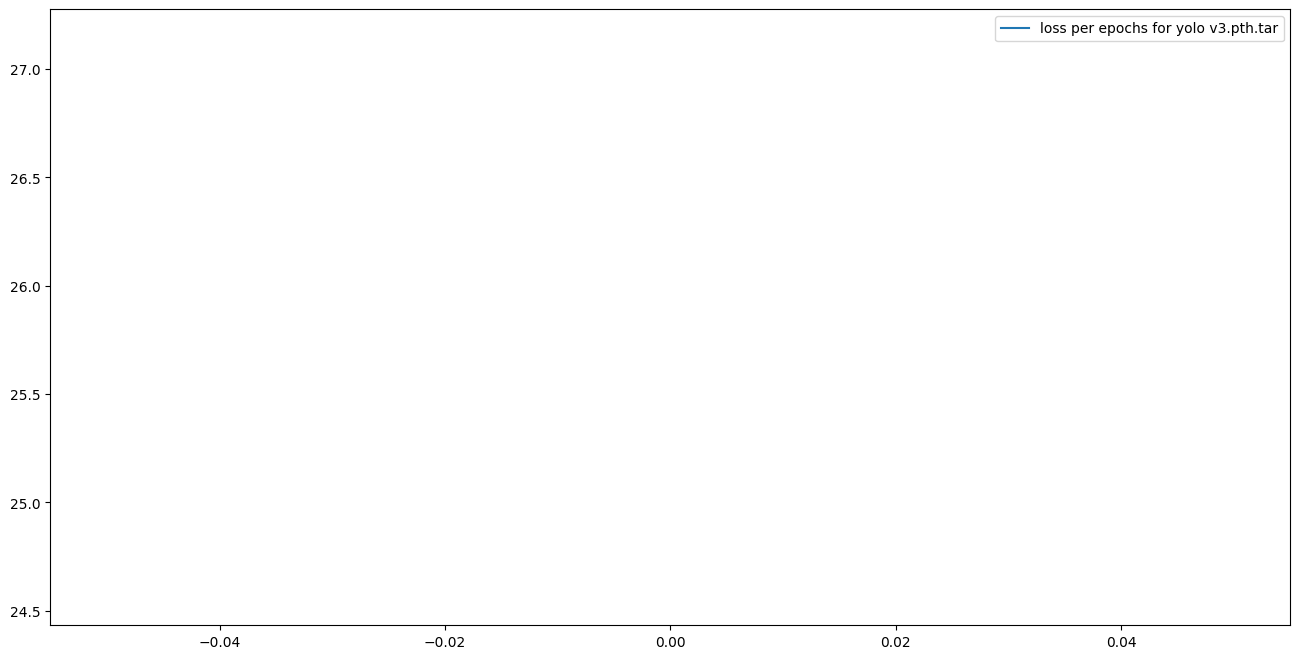

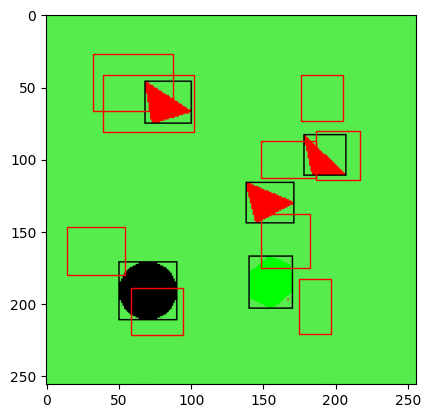

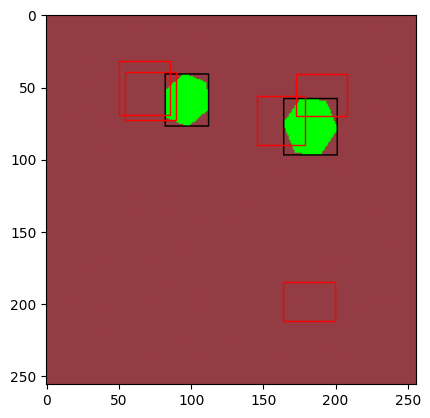

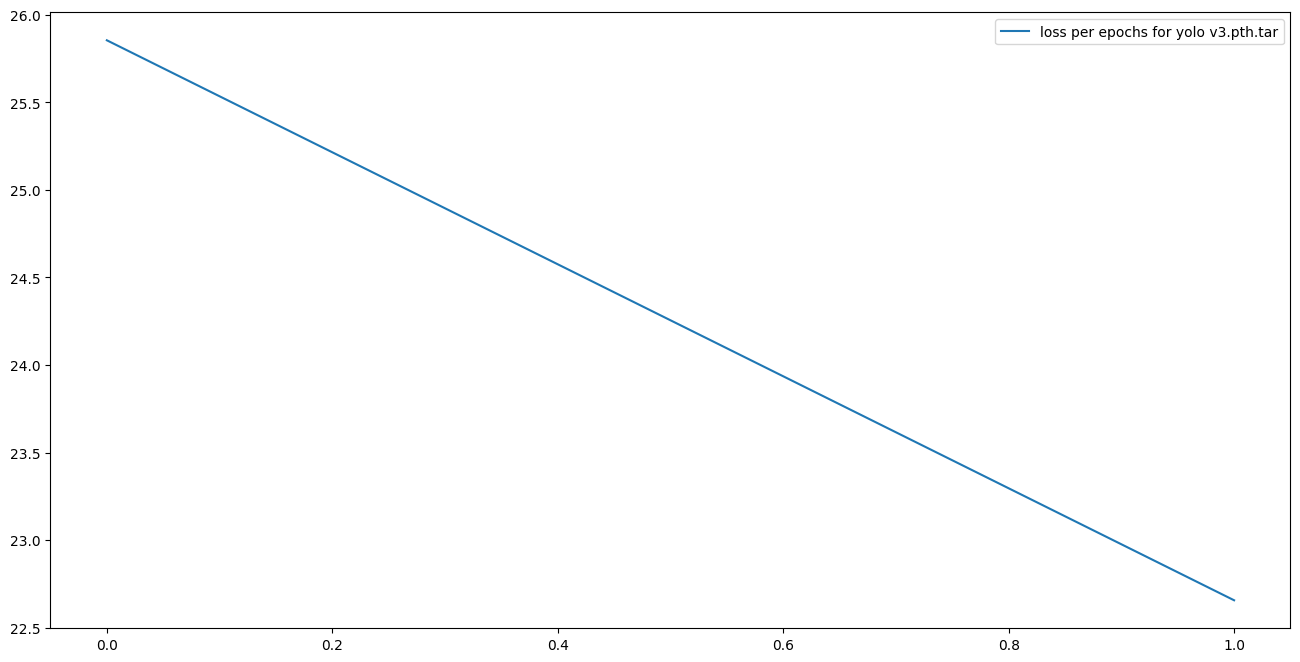

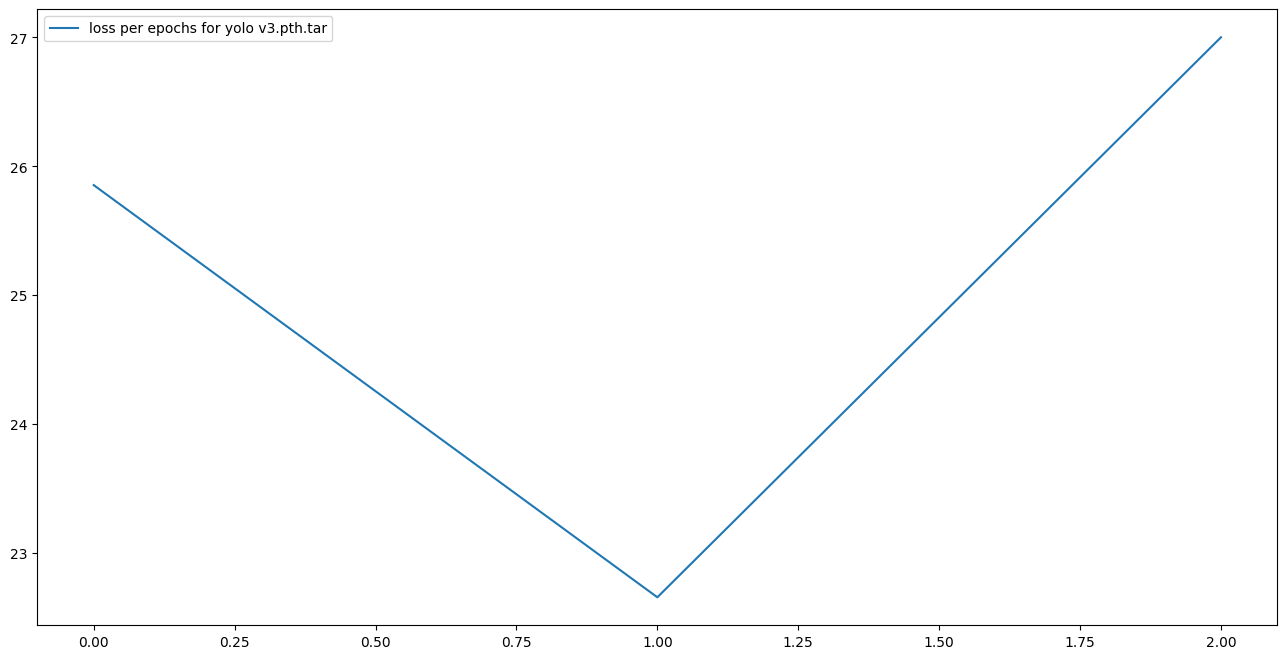

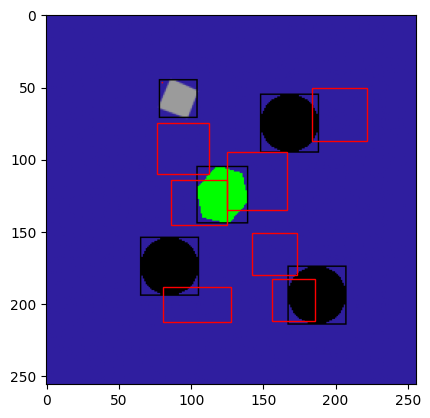

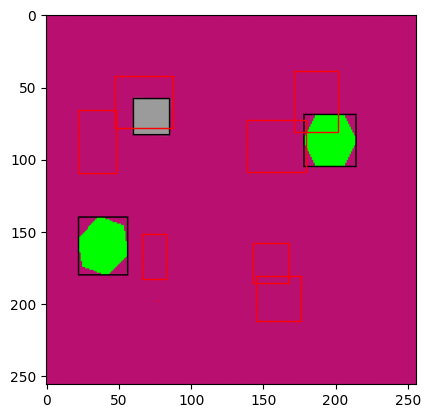

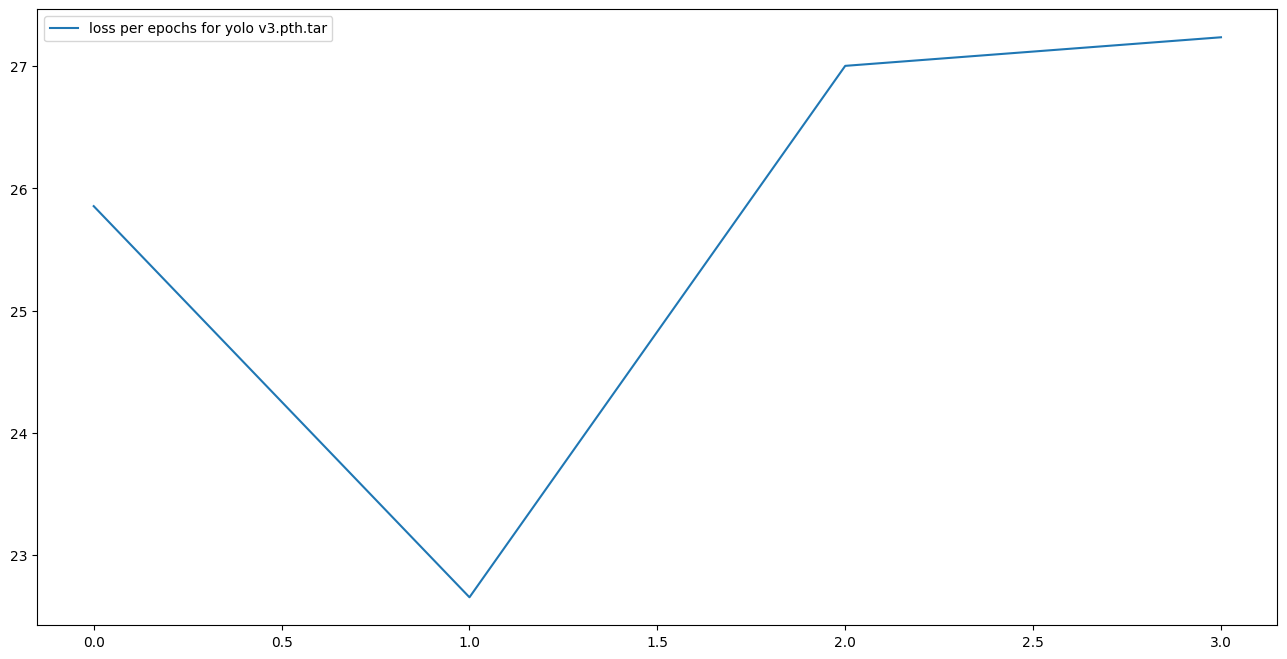

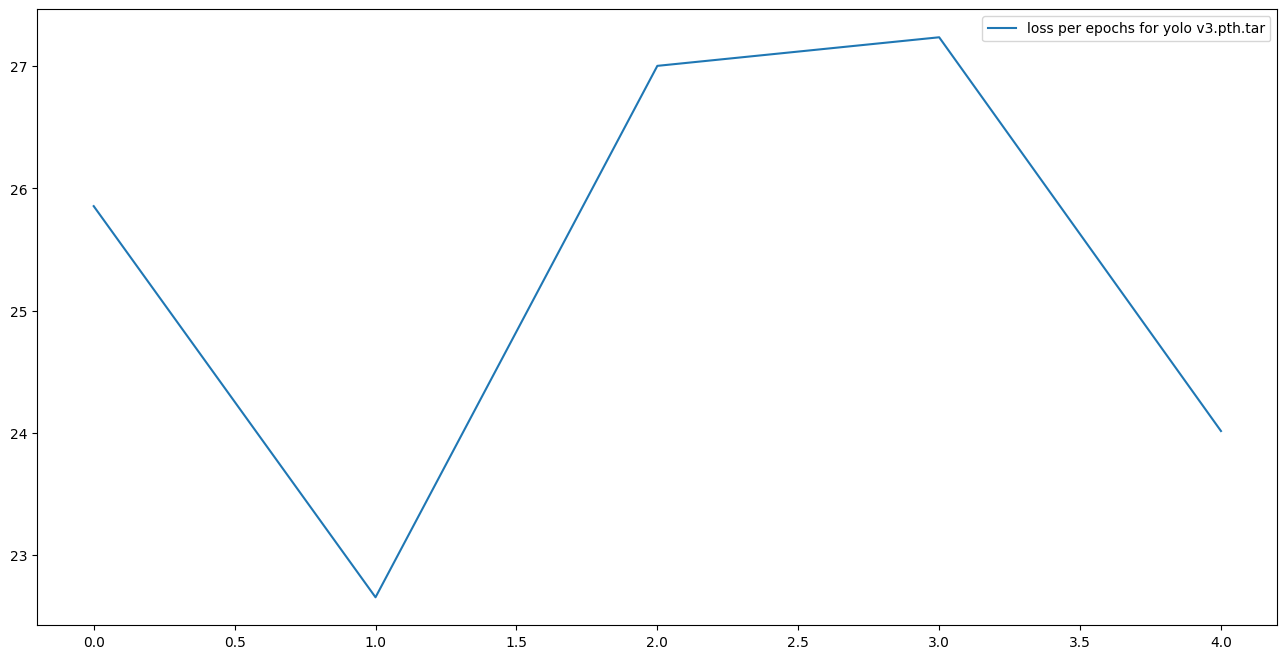

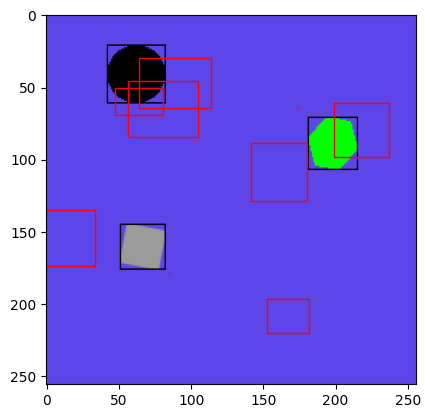

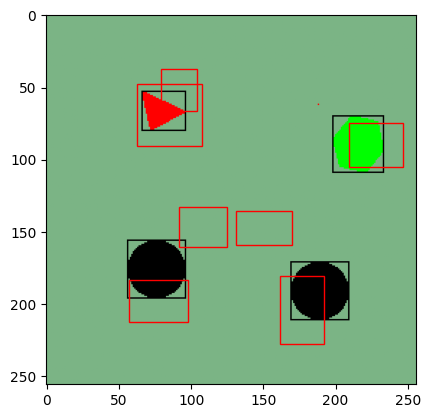

In [8]:
MODEL_VERSION = "v3" + ".pth.tar"
run(load_check = './checkpoints/yolo_4_v2.pth.tar')

In [ ]:
MODEL_VERSION = "v4" + ".pth.tar"
run(load_check = './checkpoints/yolo_4_v3.pth.tar')

=> Loaded checkpoint
LOADED WEIGHTS
## EPOCH = 0 ##  mean_avg_prec =  0.0065322816371917725

## TRAIN LOSS ## =  24.229700088500977

## TRAIN LOSS ## =  22.46245574951172

## TRAIN LOSS ## =  18.864959716796875

## TRAIN LOSS ## =  18.09330177307129

## TRAIN LOSS ## =  25.2307186126709

## TRAIN LOSS ## =  19.04824447631836

## TRAIN LOSS ## =  29.669734954833984

## TRAIN LOSS ## =  28.499858856201172

## TRAIN LOSS ## =  24.4987735748291

## TRAIN LOSS ## =  16.57015609741211

## TRAIN LOSS ## =  29.677438735961914

## TRAIN LOSS ## =  30.19795036315918

## TRAIN LOSS ## =  26.05633544921875

## TRAIN LOSS ## =  17.16382598876953

## TRAIN LOSS ## =  34.85215759277344

## TRAIN LOSS ## =  14.200469017028809
=> Saving checkpoint. LOSS =  23.70725506544113
#  INFERENCE TRAIN STARTS HERE...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v4.pth.tar      0   0.08359  0.69855      0.0    0.05625  0.01366   

          mAP.0.5  
0  tensor(0.0076)  
# 

### Collect training results

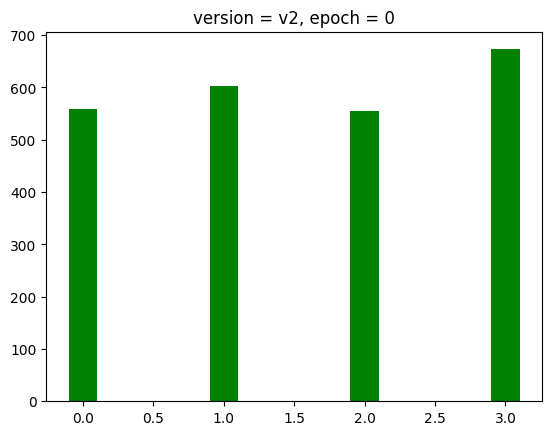

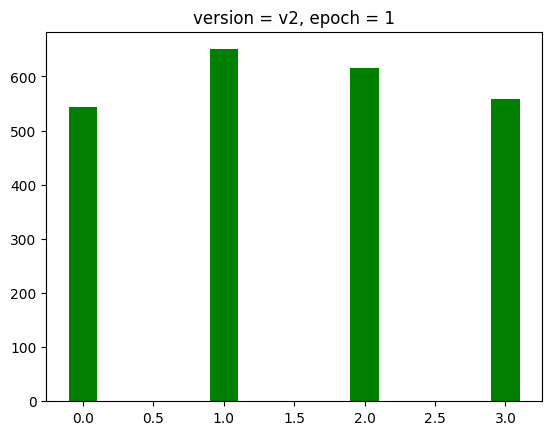

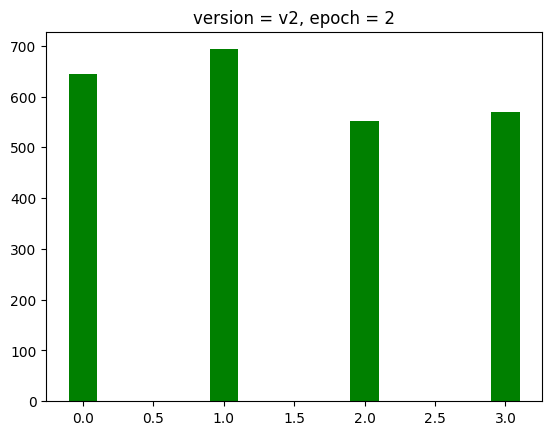

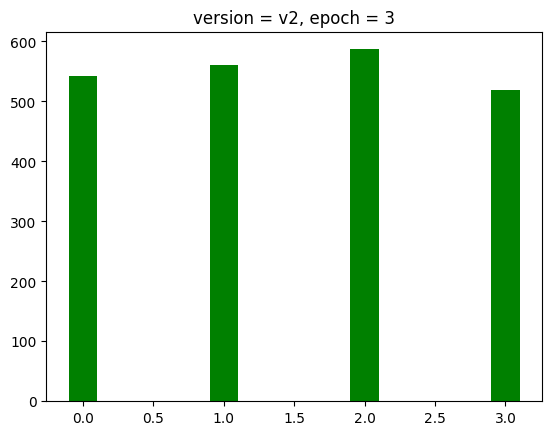

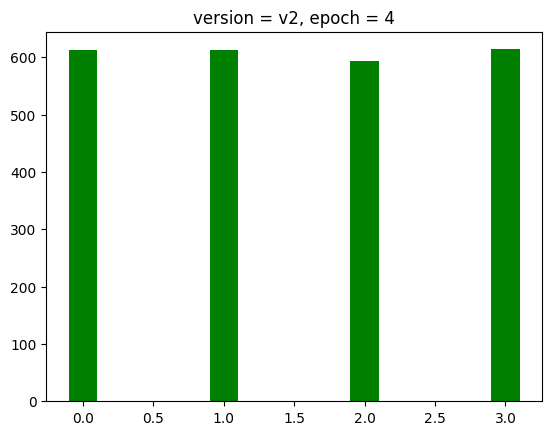

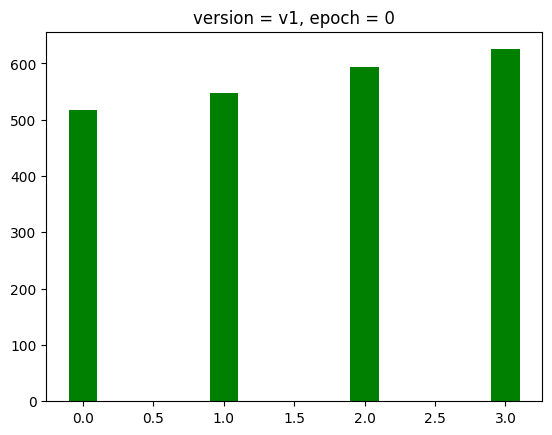

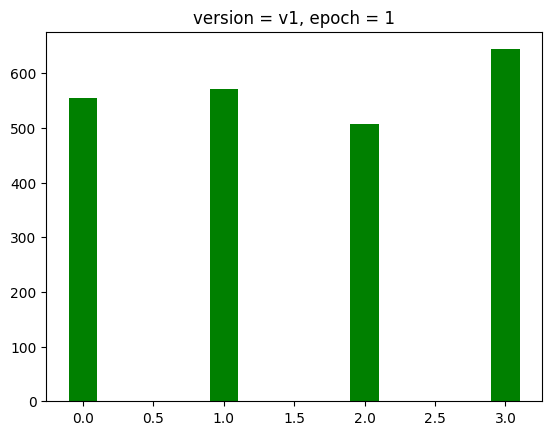

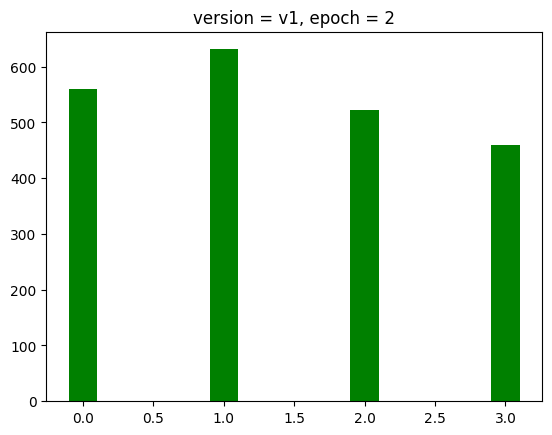

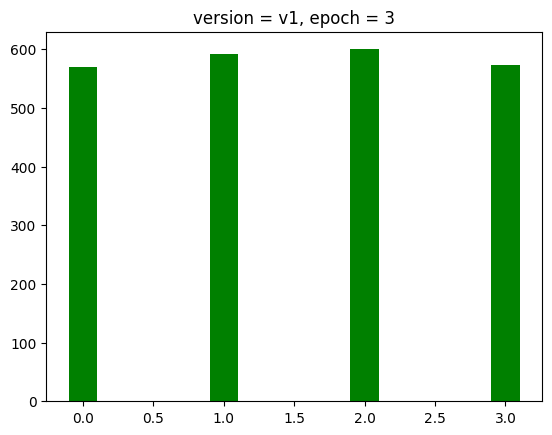

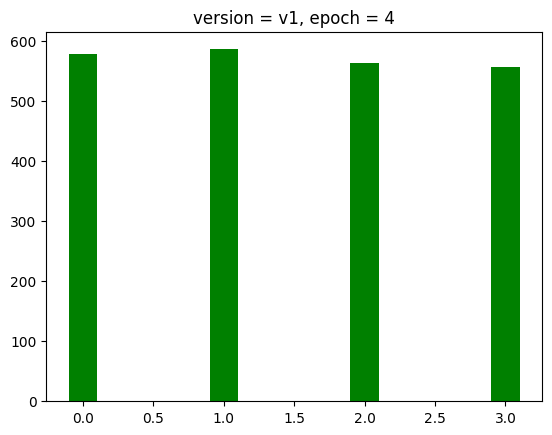

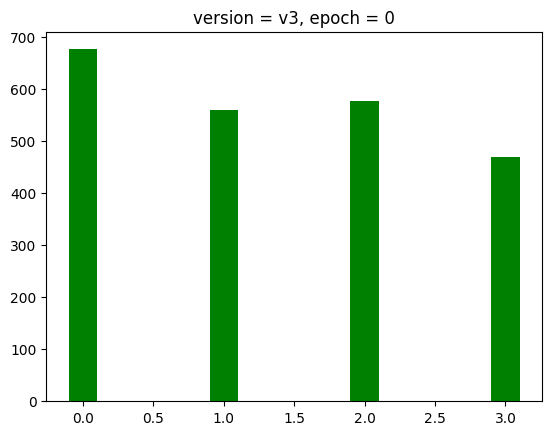

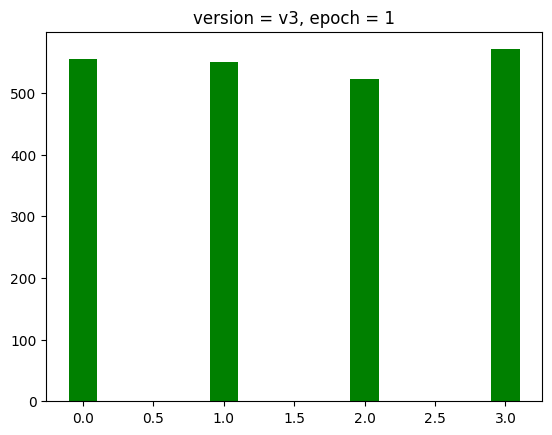

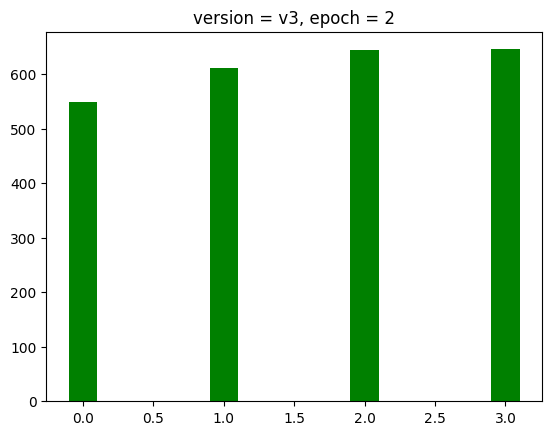

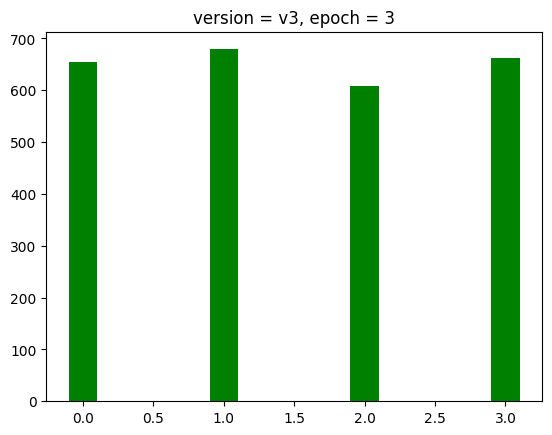

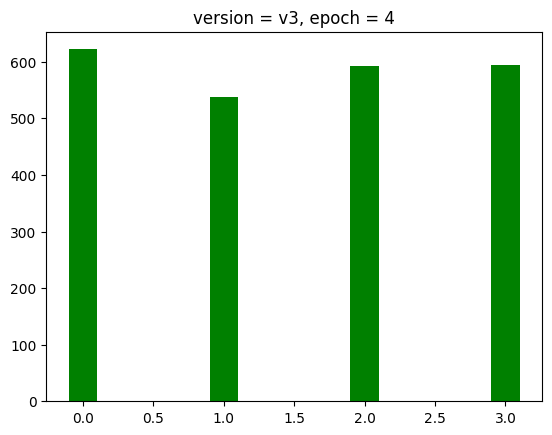

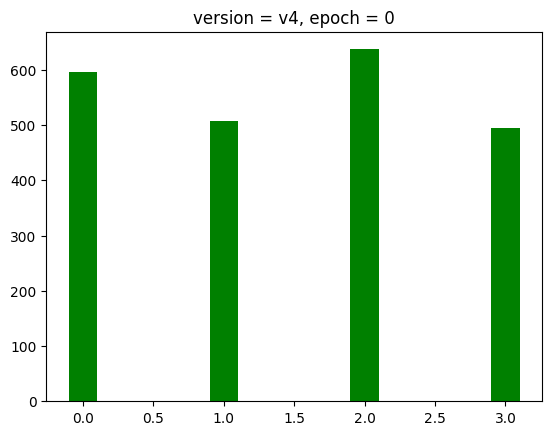

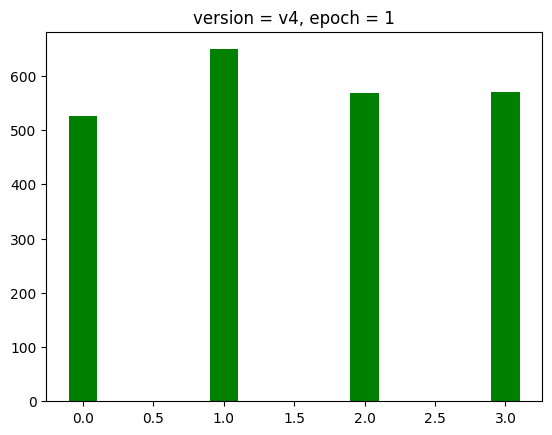

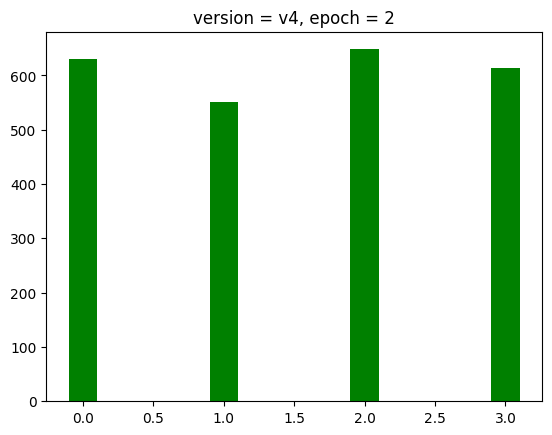

In [29]:
path_data_metaino = './runs/train/'

for info in os.listdir(path_data_metaino):
    with open(path_data_metaino + info, 'rb') as f:
        data = pickle.load(f)
        version = info.split('.')[0][-2:]
        epoch = info.split('.')[0][-4:-3]
        plt.bar(list(data['n_img_per_class_epoch'].keys()),\
                data['n_img_per_class_epoch'].values(),  color='g', width = 0.2)
        plt.title(f"version = {version}, epoch = {epoch}")
        plt.show()


In [42]:
path_data_metaino = './runs/test/'
df = pd.DataFrame()
for info in os.listdir(path_data_metaino):

  if str(info).split('.')[-1] == 'csv':
    print(info)
    df_ = pd.read_csv(path_data_metaino + info)
    df = pd.concat([df_, df], axis = 0)


metrics_v2.pth.tar__0.csv
metrics_v2.pth.tar__2.csv
metrics_v2.pth.tar__4.csv
metrics_v1.pth.tar__0.csv
metrics_v1.pth.tar__2.csv
metrics_v1.pth.tar__4.csv
metrics_v3.pth.tar__0.csv
metrics_v3.pth.tar__2.csv
metrics_v3.pth.tar__4.csv
metrics_v4.pth.tar__0.csv


In [43]:
df

,Unnamed: 0,MODEL_VERSION,epoch,mean_iou,max_iou,min_iou,precision,recall,mAP.0.5
0,0,v4.pth.tar,0,0.079577,0.675462,0.0,0.055352,0.016253,tensor(0.0002)
0,0,v3.pth.tar,4,0.061986,0.620899,0.0,0.028761,0.022359,tensor(0.0059)
0,0,v3.pth.tar,2,0.060522,0.715168,0.0,0.043825,0.037451,tensor(0.0043)
0,0,v3.pth.tar,0,0.059647,0.697814,0.0,0.020169,0.027453,tensor(0.0024)
0,0,v1.pth.tar,4,0.033657,0.558289,0.0,0.011088,0.020251,tensor(0.0240)
0,0,v1.pth.tar,2,0.025418,0.535605,0.0,0.003120,0.006042,tensor(0.0009)
0,0,v1.pth.tar,0,0.001723,0.259182,0.0,0.000000,0.000000,tensor(0.)
0,0,v2.pth.tar,4,0.036170,0.688167,0.0,0.038919,0.049201,tensor(0.0028)
0,0,v2.pth.tar,2,0.036025,0.659846,0.0,0.023264,0.041158,tensor(0.0054)
0,0,v2.pth.tar,0,0.027968,0.603167,0.0,0.004632,0.007792,tensor(0.)


# 3

## Model changes in architecture

In [11]:

class CNNBlock(nn.Module):
    def __init__(self , in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


architecture_config = [ # from paper
    (7, 64, 2, 3), # kernel / out_ch /  stride / padding
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class YOLO_model_init_weights(nn.Module):


    def __init__(self, in_channels = 3, architecture_config = architecture_config,  **kwargs):
        super(YOLO_model, self).__init__()
        self.in_channels = in_channels
        self.arch = architecture_config
        self.conv_model = self._create_conv(self.arch)
        self.fc_model = self._create_fc(**kwargs)
        self.apply(self._init_weights)

    def _create_conv(self, arch):

        layers = []
        for layer in arch:
            if type(layer) == tuple:
                layers += [CNNBlock(in_channels = self.in_channels, out_channels = layer[1], kernel_size = layer[0],  stride=layer[2], padding=layer[3])]
                self.in_channels = layer[1]

            if type(layer) == str:
                layers += [nn.MaxPool2d(2, 2)]
            if type(layer) == list:
                n_repetitions = layer[-1]
                for _ in range(n_repetitions):
                    l1 = layer[0]
                    l2 = layer[1]  # [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
                    layers += [CNNBlock(in_channels=self.in_channels, out_channels=l1[1], kernel_size = l1[0],stride=l1[2], padding=l1[3])]
                    layers += [CNNBlock(in_channels=l1[1], out_channels=l2[1], kernel_size=l2[0], stride=l2[2], padding=l2[3])]
                    self.in_channels = l2[1]
        return nn.Sequential(*layers)

    def _create_fc(self, patch_size, n_boxes_per_img, input_img_width, n_classes):
        n_pathes = input_img_width // n_boxes_per_img
        fc_model = nn.Sequential(

            nn.Flatten(),
            nn.Linear(1024*patch_size*patch_size, n_pathes*n_pathes),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.1),
            nn.Linear( n_pathes*n_pathes, patch_size*patch_size*(n_boxes_per_img*5  + n_classes))


        )

        return fc_model

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

        if isinstance(module,  nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

        if isinstance(module, nn.LayerNorm):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()




    def forward(self, img):
        img = self.conv_model(img)
        res = self.fc_model(img)

        return  res



NameError: ignored

## Create DataLoaders

In [ ]:
tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])



train_dataset_no_hexagon = ShapeDatasetFromGenerator(transform = tfs, total_len_annoattions = TRAIN_SIZE_DATA)
test_dataset_no_hexagon = ShapeDatasetFromGenerator(transform = tfs, total_len_annoattions = TEST_SIZE_DATA)
test_dataset_hexagon = ShapeDatasetFromGenerator(transform = tfs, total_len_annoattions = TEST_SIZE_DATA)

train_loader_no_hexagon = DataLoader(dataset=train_dataset_no_hexagon, batch_size=BATCH_SIZE, drop_last=False)
test_loader_no_hexagon = DataLoader(dataset=test_dataset_no_hexagon, batch_size=BATCH_SIZE, drop_last=False)
test_loader_hexagon = DataLoader(dataset=test_dataset_hexagon, batch_size=BATCH_SIZE, drop_last=False)


## Set up model start_learning checkpoint

In [ ]:
loss_fn = lossYolov1()
model = YOLO_model_init_weights(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)
opt = optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
loss_per_epoch = []

model = model.to(DEVICE)

In [ ]:
save_checkpoint(-1, model, optimizer,-1, path = CHECK_PATH, filename="/start_learning"):

In [ ]:
EPOCHS = 10 # 16
TEST_SIZE_DATA = 24
# testing on 3000 images requiers with TEST_SIZE_DATA = 24 requires 243 iteration
TRAIN_SIZE_DATA = 64
# training on 12_000 images with TRAIN_SIZE_DATA = 64 requires EPOCHS = 189

In [ ]:

def run(train_loader, save_dataframe_path=TEST_RUNS_RES, load_check = ''):
    try:
        model, opt = load_checkpoint( checkpoint_path= load_check, model=model, optimizer=opt)
        print("LOADED WEIGHTS")
    except:
        print("\n====================\n  looks like we gonna train from scratch  \n======================")
    for epoch in range(EPOCHS):

        avg_train_loss , n_img_per_class_epoch , n_images = train_function(yolo_model=model, train_loader = train_loader, \
                           optimizer = opt, loss_fn = loss_fn, model_version = MODEL_VERSION, load_check=load_check)

        loss_per_epoch.append(avg_train_loss)

        save_checkpoint(epoch = epoch, model = model, optimizer = opt, LOSS = avg_train_loss,\
                        path = CHECK_PATH, filename=f"/yolo_{epoch}_" + MODEL_VERSION )
        save_losses(loss_per_epoch, MODEL_VERSION)
        save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION)


In [ ]:
run(train_loader = )

20 раз:
1)	Провести отдельно тестирование нейросетевой модели на тестовой выборке №1 и №2. Для каждой выборки зафиксировать значения precision и recall для IoU > 0.5,
 а также количество детектированных фигур и общее количество для каждого типа  фигуры.

2)	Сгенерировать выборку из 400 изображений, содержащую обязательно гексагон (но не только), и добавить ее в обучающую выборку (на первой итерации обучающая выборка станет 12400 изображений, на второй 12800 и т.д.).
3)	Дообучить нейросетевую модель c позиции start_learning.
